In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [3]:
from spacy.lang.en import English
nlp = English()

In [3]:
url = 'http://www.plosone.org/article/fetchSingleRepresentation.action?uri=info:doi/10.1371/journal.pone.0026752.s001'
labmt = pd.read_csv(url, skiprows=2, sep='\t', index_col=0) 

In [4]:
felicidad_no_centrada = labmt.happiness_average.to_dict()
felicidad_centrada    = (labmt.happiness_average - labmt.happiness_average.mean()).to_dict()

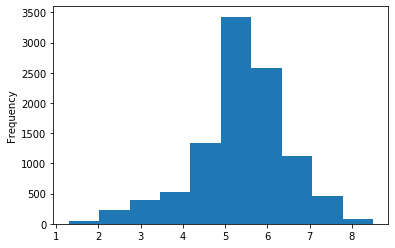

In [247]:
labmt.happiness_average.plot.hist()

In [248]:
labmt.happiness_average.describe()

count    10222.000000
mean         5.375240
std          1.084905
min          1.300000
25%          4.900000
50%          5.440000
75%          6.020000
max          8.500000
Name: happiness_average, dtype: float64

## Sentiment140

* http://help.sentiment140.com/for-students
* https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf

In [6]:
df = pd.read_csv('sentiment140/testdata.manual.2009.06.14.csv',
                 header=None, index_col='id', names=['sentiment','id','text'], usecols=[0,1,5])

In [7]:
clases = {0:'negativo',2:'neutral',4:'positivo'}

df.sentiment = df.sentiment.apply(clases.get)

In [8]:
df = df[df.sentiment.isin(['positivo','negativo'])].copy()

In [9]:
df.head()

,sentiment,text
id,,
3,positivo,@stellargirl I loooooooovvvvvveee my Kindle2. ...
4,positivo,Reading my kindle2... Love it... Lee childs i...
5,positivo,"Ok, first assesment of the #kindle2 ...it fuck..."
6,positivo,@kenburbary You'll love your Kindle2. I've had...
7,positivo,@mikefish Fair enough. But i have the Kindle2...


In [10]:
df['tokens'] = df.text.apply(lambda text: [t.lower_ for t in nlp(text)])

df['puntajes'] = df.tokens.apply(lambda tokens: np.array(list(map(felicidad_centrada.get, tokens)), dtype=np.float))

df['puntaje'] = df.puntajes.apply(lambda p: np.mean(p[~np.isnan(p)])).fillna(0)

In [11]:
from sklearn.metrics import accuracy_score

accuracy_score(df.sentiment, df.puntaje.apply(lambda p: 'positivo' if p >= 0 else 'negativo'))

0.7966573816155988

## Erowid

In [2]:
df = pd.read_json('erowid/erowid.json.gz', lines=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31221 entries, 0 to 31220
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   author     31169 non-null  object 
 1   weight     29139 non-null  object 
 2   doses      31221 non-null  object 
 3   year       31168 non-null  object 
 4   id         31168 non-null  float64
 5   gender     31168 non-null  object 
 6   age        31168 non-null  object 
 7   published  31168 non-null  object 
 8   tags       31168 non-null  object 
 9   text       31221 non-null  object 
dtypes: float64(1), object(9)
memory usage: 2.4+ MB


In [5]:
print(df.iloc[0].text)

A-PVP - Oral Experience

One evening, a vulcan man was bored. He wanted to test his ability to keep control of his mind's. Since he was just finishing a PvP match, he decided to try the substance.

SETTING/ ENVIRONMENT

TUVOK said he would take his usual preferred dose to start. No other substances were taken simultaneously. Last night's vulcan 'incense' had completely worn off. In his quarters laid on bed at home with cats in and out of room (pick-me-up). Parents sat across the house (threat). Not hungry but only ate lightly, one snack immediately before starting.

Measured 2 x 50mg doses with empty capsules and closed (logical!). Previously had confirmed his vulcan physiology was not allergic and will live long and prosper after the test.

BEGIN (t = 00:00)
Washed down the 2 capsules together with a glass of lemonade. Laid back and waited patiently with voyager on in the background, moderate 'mood' lighting.

CURIOUS (t + 00:20)
Noticed: Can 'taste' in breathing that the capsules hav

In [6]:
len(df)

31221

### Data wrangling

#### ID / Índice

In [7]:
df.dropna(subset=['id'], inplace=True)
df.id = df.id.astype(int)
df.set_index('id', inplace=True)

#### Texto

Remover párrafos.

In [8]:
import re

df.text = df.text.apply(lambda x: re.sub('[\n\s]+', ' ', x))

Más largo que un tweet.

In [9]:
df = df[df.text.str.len() > 140].copy()

#### Edad

In [10]:
df.age  = pd.to_numeric(df.age,  errors='coerce')

#### Año

In [11]:
df.year = pd.to_numeric(df.year, errors='coerce')

#### Sexo

In [12]:
df.gender.replace('Not Specified', np.nan, inplace=True)
df.gender.value_counts()

Male      24823
Female     4390
Name: gender, dtype: int64

#### Peso corporal

In [13]:
def conversión_lb_a_kg(string):
    if type(string) is not str:
        return np.nan
    
    masa, unidad = string.split(' ')
    masa = float(masa)
    
    if unidad == 'lb':
        masa /= 2.205
    
    return round(masa, 1)

In [14]:
df.weight = df.weight.apply(conversión_lb_a_kg)

#### Fecha de publicación

In [15]:
df.published = pd.to_datetime(df.published, errors='coerce')

#### Dosaje / Substancias

Frecuencia de cantidad de dosis.

In [16]:
df.doses.apply(len).value_counts(sort=False)

3      3220
1     16817
0       416
2      7247
7       253
6       420
5       777
4      1595
14       20
9       130
11       27
12       20
13        8
8       146
10       43
Name: doses, dtype: int64

In [17]:
df['substances'] = df.doses.apply(lambda dosis: len(set(map(lambda x: x.get('substance'), dosis))))

In [18]:
df.substances.value_counts()

1     19405
2      7091
3      2596
4       979
0       416
5       366
6       152
7        83
8        31
9        12
10        4
11        2
12        2
Name: substances, dtype: int64

### Mono consumo

Podríamos hacer un conteo similar para los métodos pero por ahora vamos a suponer que importa más la substancia que el método de ingesta.

In [19]:
df = df[df.substances.eq(1)].drop(columns='substances')

In [20]:
df['substance'] = df.doses.apply(lambda doses: doses[0]['substance'])

In [21]:
df.substance.value_counts()

Salvia divinorum    1425
Cannabis             955
MDMA                 892
LSD                  795
Mushrooms            789
                    ... 
Pentazocine            1
Detomidine             1
Pedicularis spp.       1
MDMB-CHMICA            1
bk-DMDBD               1
Name: substance, Length: 623, dtype: int64

In [22]:
df.substance.nunique()

623

### NLP

https://spacy.io/api/sentencizer
    
A simple pipeline component, to allow custom sentence boundary detection logic that doesn’t require the dependency parse. By default, sentence segmentation is performed by the DependencyParser, so the Sentencizer lets you implement a simpler, rule-based strategy that doesn’t require a statistical model to be loaded. The component is also available via the string name "sentencizer". After initialization, it is typically added to the processing pipeline using nlp.add_pipe.

In [21]:
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [22]:
df['doc'] = df.text.apply(nlp)

df.drop(columns='text', inplace=True)

In [23]:
df['sents'] = df.doc.apply(lambda doc: len(list(doc.sents)))

df.sents.quantile([.1,.25,.5,.75,.9])

0.10    10.0
0.25    18.0
0.50    33.0
0.75    59.0
0.90    95.0
Name: sents, dtype: float64

Histograma de oraciones.

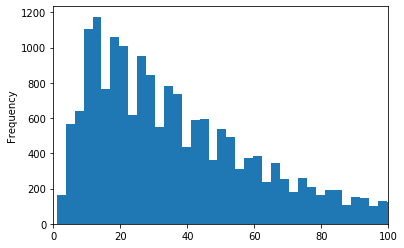

In [236]:
df.sents.plot.hist(bins=500)
plt.xlim(0,100);

Histograma de tokens.

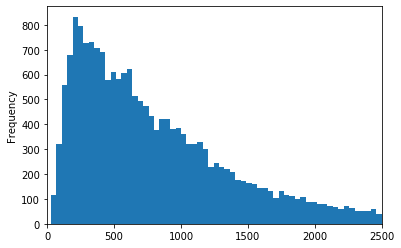

In [232]:
df.doc.apply(len).plot.hist(bins=500)
plt.xlim(0,2500);

Histograma de caracteres.

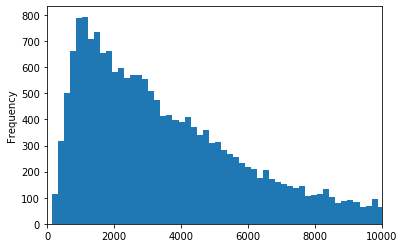

In [234]:
df.doc.apply(lambda doc: len(doc.text)).plot.hist(bins=500)
plt.xlim(0,10000);

---

Upsamplear/downsamplear a 33 oraciones (puntos en realidad). Proponemos usar un tercio de la mediana como cota inferior para la cantidad de oraciones.

In [24]:
df = df[df.sents >= 11].copy()

### Dataset

In [25]:
len(df) *33

571263

In [26]:
sents_df = []

for doc, row in df[:10].iterrows():
    dg = pd.DataFrame(map(str, row.doc.sents), columns=['sents'])
    dg.index.name = 'pos'
    dg.reset_index(inplace=True)
    dg['doc'] = doc
    dg['label'] = None
    dg.set_index(['doc','pos'], inplace=True)
    
    sents_df.append(dg)

sents_df = pd.concat(sents_df)

In [27]:
sents_df.to_pickle('anotaciones.pkl')

1. Escoger un documento al azar sin clasificación previa.
2. Clasificar las oraciones del documento en negativas, neutras (ausencia de etiqueta), positivas. Se clasifican por documento para tener contexto.
3. Se entrena un modelo y se clasifican oraciones para obtener nuevas oraciones para etiquetar.

In [35]:
sents_df[sents_df.label.isnull()].sample(1).index.get_level_values('doc').unique().tolist()[0]

111386

In [96]:
sents_df.groupby('doc').label.filter(lambda g: g.all())

doc     pos
109479  0      None
        1      None
        2      None
        3      None
        4      None
               ... 
111922  37     None
        38     None
        39     None
        40     None
        41     None
Name: label, Length: 485, dtype: object

In [32]:
doc = 103149

sents_df.loc[doc]

,sents,label
pos,,
0,Acacia Confusa and Its Oral Activity Goal In o...,None
1,Procedure Boiled 3 tbsp of shredded Acacia con...,None
2,Then collected the water and boiled the bark i...,None
3,The next extract was combined with the first a...,None
4,Then let cooled.,None
5,Bio-essay 0:00 The brew was consumed on a near...,None
6,"Very bitter tasting, although not as bad as ay...",None
7,0:03 Slight body chills.,None
8,0:08 Lethargy/moderate physical high began to ...,None


In [28]:
doc = 103149

In [79]:
for pos, row in sents_df.loc[doc].iterrows():
    print(row.sents)
    print()
    i = input()
    print(i)
    raise

Last night I had the opportunity to try my ayahuasca brew.



 s


s


RuntimeError: No active exception to reraise

### Análisis de sentimiento

In [243]:
from spacy.tokens import Doc, Span, Token

In [ ]:
Token.set_extension('happiness', method=lambda token: felicidad_centrada.get(token.lower_, np.nan))

Span.set_extension('happiness', method=lambda span: np.nanmean([token._.happiness() for token in span]))

Doc.set_extension('sents_happiness', method=lambda doc: np.array([sent._.happiness() for sent in doc.sents]))

Doc.set_extension('happiness', method=lambda doc: np.nanmean(doc._.sents_happiness()))

In [274]:
df['felicidad'] = df.doc.apply(lambda doc: doc._.happiness())

/home/matias/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


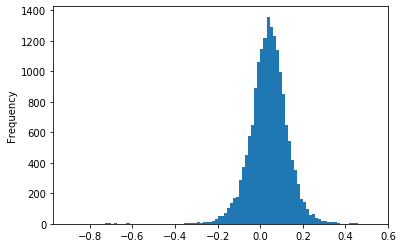

In [282]:
df.felicidad.plot.hist(bins=100);

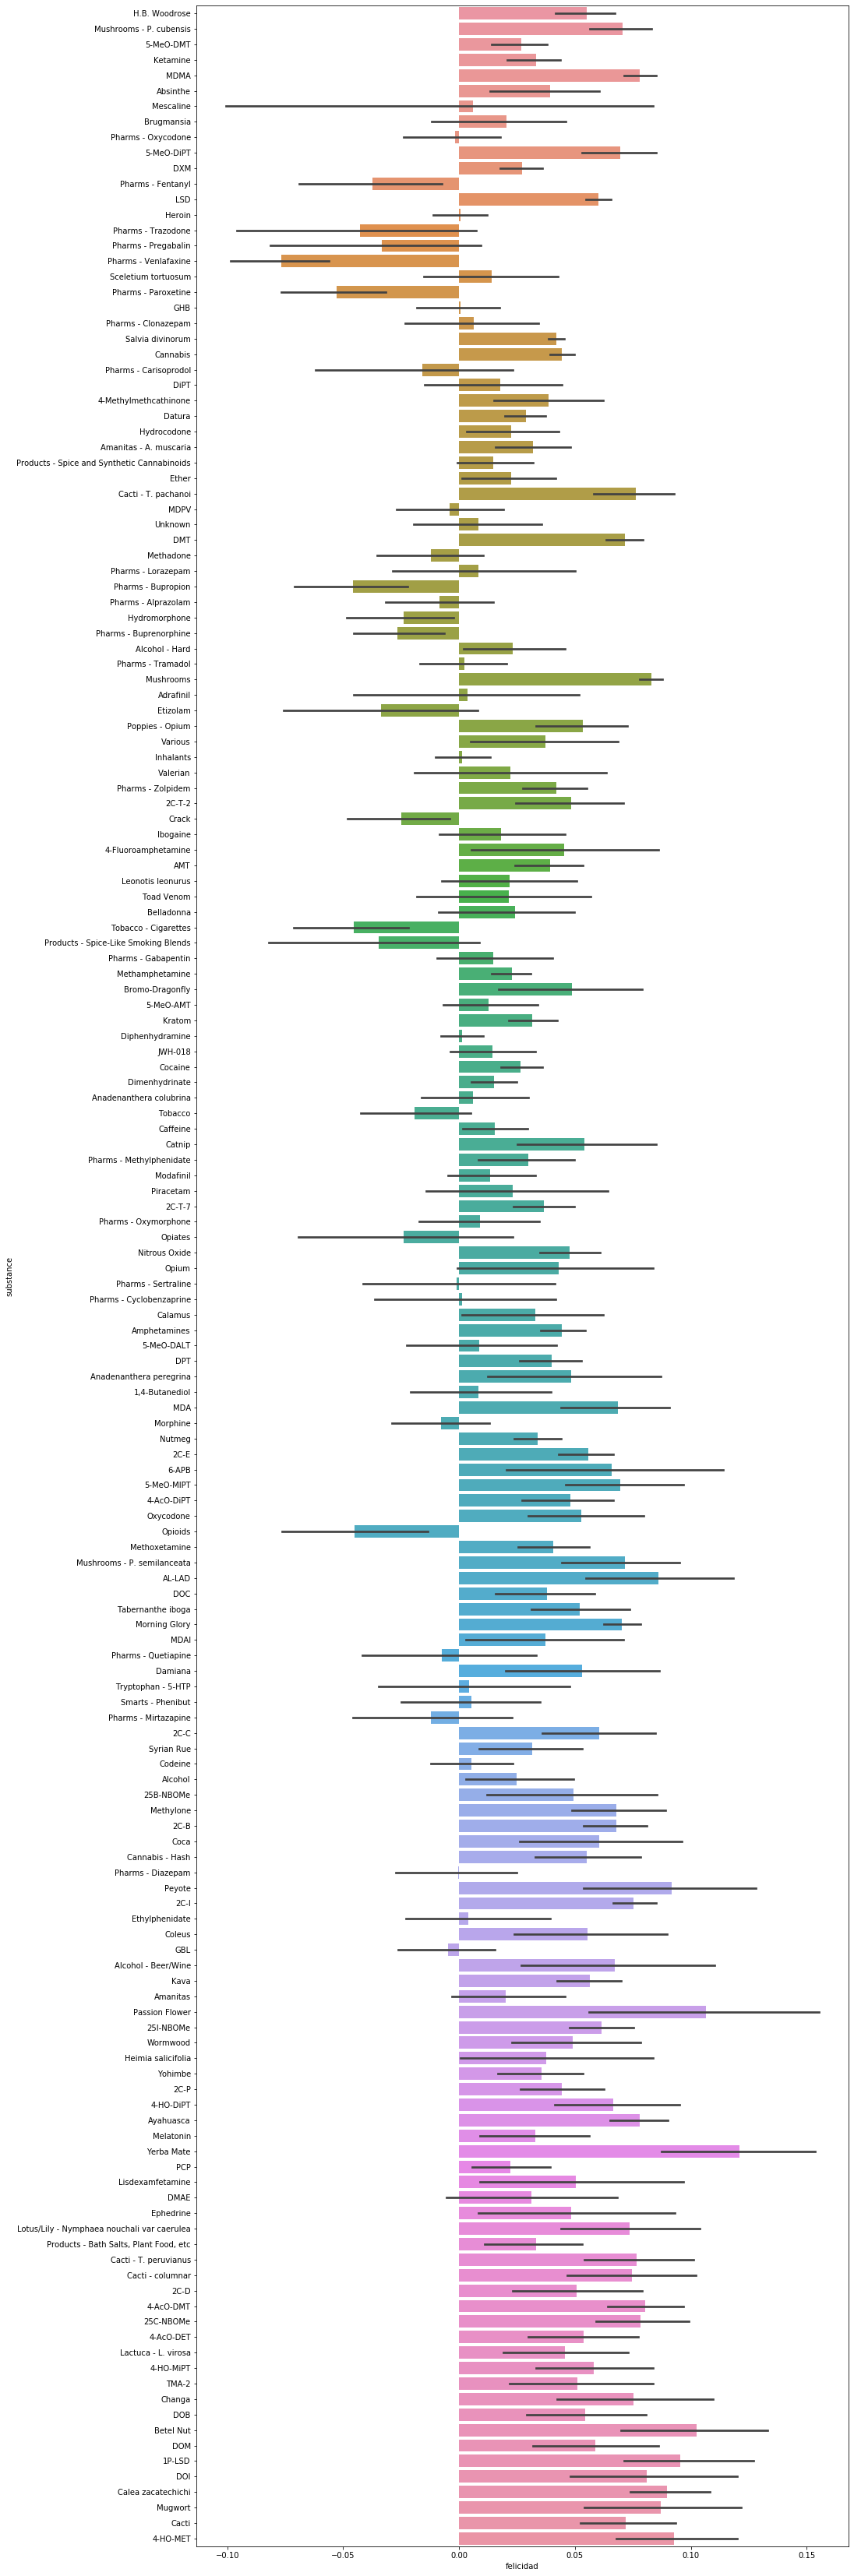

In [296]:
fig, ax = plt.subplots(figsize=(15,60))

data = df.groupby('substance').filter(lambda g: len(g) >= 15).sort_values('felicidad')

sn.barplot(ax=ax, data=data, y='substance', x='felicidad');

### Categorías

In [23]:
categorías = {
    1 : 'Psychedelic (other)',
    2 : 'Psychedelic (serotonergic)',
    3 : 'Psychedelic (entactogen)',
    4 : 'Psychedelic (dissociative)',
    5 : 'Depressant/sedative',
    6 : 'Stimulant',
    7 : 'Delirant',
    8 : 'MAOI',
    9 : 'Antipsychotic/antidepressant',
    10: 'Oneirogen',
}

clasificación = pd.read_csv('enzo/clasificación_drogas.csv', header=None, names=['substance', 'principal', 'secondary'])

clasificación.principal = clasificación.principal.apply(lambda x: categorías[x])
clasificación.secondary = clasificación.secondary.apply(lambda x: categorías[x])

clasificación.substance = clasificación.substance.str.strip()

In [24]:
clasificación.head()

,substance,principal,secondary
0,Cannabis,Depressant/sedative,Psychedelic (other)
1,Salvia divinorum,Psychedelic (other),Psychedelic (other)
2,MDMA,Psychedelic (entactogen),Stimulant
3,LSD,Psychedelic (serotonergic),Psychedelic (serotonergic)
4,DXM,Psychedelic (dissociative),Delirant


In [25]:
df = pd.merge(df, clasificación, on='substance', how='left')

Substancias que no pudieron ser clasificadas.

In [328]:
df.principal.notnull().value_counts()

True     10195
False     7114
Name: principal, dtype: int64

In [325]:
df[df.principal.isnull()].substance.value_counts()

Mushrooms                                      745
Morning Glory                                  329
Methamphetamine                                309
Kratom                                         267
Mushrooms - P. cubensis                        260
Amphetamines                                   237
H.B. Woodrose                                  223
Heroin                                         155
Inhalants                                      146
Nitrous Oxide                                  137
Pharms - Tramadol                              137
Pharms - Zolpidem                              136
Amanitas - A. muscaria                         127
Cacti - T. pachanoi                            109
Pharms - Oxycodone                              92
Absinthe                                        90
Products - Spice and Synthetic Cannabinoids     88
Pharms - Methylphenidate                        70
Alcohol - Hard                                  65
Poppies - Opium                

In [331]:
df.principal.value_counts()

Psychedelic (serotonergic)    3203
Depressant/sedative           1992
Psychedelic (other)           1492
Psychedelic (entactogen)      1100
Stimulant                      890
Psychedelic (dissociative)     762
Delirant                       697
Oneirogen                       58
MAOI                             1
Name: principal, dtype: int64

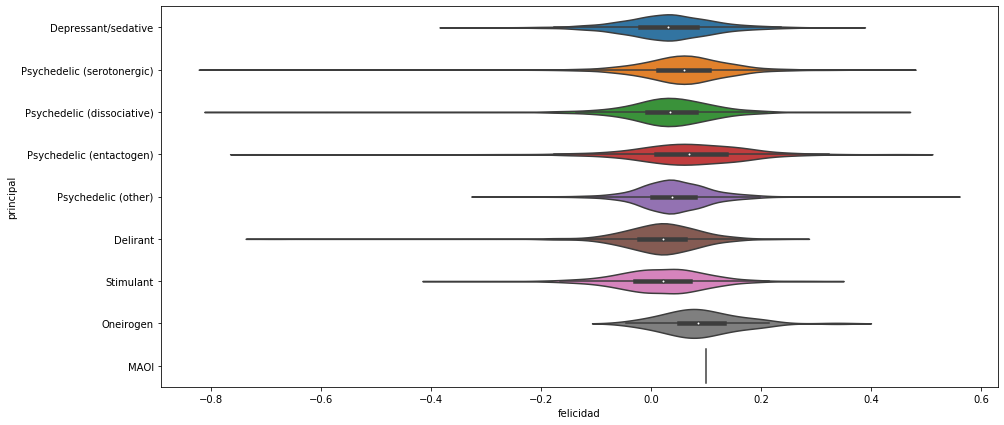

In [332]:
fig, ax = plt.subplots(figsize=(15,7))
sn.violinplot(x='felicidad', y='principal', data=df);

---

**TODO**: upsampling / downsampling

tags ['2C-E', 'Small Group', 'Retrospective / Summary', 'Multi-Day Experience', 'Hangover / Days After', 'Health Benefits'] 

happiness 0.09301997080795212 

 0  My girlfriend, J, and I acquired 6 grams of 2C-E HCl powder from an online vendor, and had 4 amazingly powerful 2C-E trips over the course of approximately one month, starting at the beginning of December 2007, and going until the first week of January 2008.
 1  The effects of 2C-E we got went far beyond the 9-12 hours we actually tripped out.
 2  Both J and I had a distinct and very powerful afterglow from 2C-E that lasted several months.
 3  We both decided, as a direct result of our 2C-E use, that we no longer wished to consume alcohol as an intoxicant, and now 4.5 months later we are both adhering to our decisions very well.
 4  What I believe 2C-E did to us was help us to become aware of the cultural conditioning we have all been subject to for our whole lives to drink alcohol.
 5  At some point along our little 2C-E odys

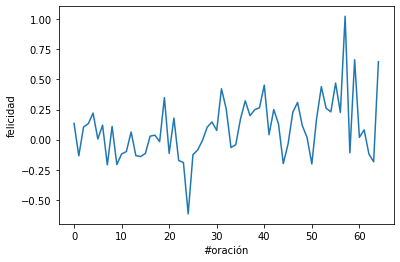

In [345]:
n=2009

doc = df.iloc[n].doc

print('tags', df.iloc[n].tags, '\n')
print('happiness', doc._.happiness(), '\n')

sn.lineplot(data=doc._.sents_happiness())
plt.ylabel('felicidad')
plt.xlabel('#oración')

for i, oración in enumerate(doc.sents):
    print('%2d ' % i, oración)

https://github.com/Separius/awesome-sentence-embedding

**Enfoque A**

word embeddings (provenientes de word2vec o GloVe) -> contextualized word embeddings (mediante una función tipo encoder) -> sentence embeddings (mediante una función de pooling)

**Enfoque B**

Otra estrategia es usar un encoder de embeddings de oraciones (similar a word2vec pero para oraciones, como doc2vec).

Este me gustó especialmente:
[No Training Required: Exploring Random Encoders for Sentence Classification](https://arxiv.org/abs/1901.10444)

----

Attention is all you need (estado del arte)

https://arxiv.org/pdf/1706.03762.pdf

Para entenderlo hay que leer algunas otras cosas antes. Esto puede ayudar:
https://docs.google.com/presentation/d/1CbSZdpIWn_GEv3xblm7MjMK6CAny79t0ntNWhLeg9Sk/edit?usp=sharing

1) Agregar al valor medio desvio estandar (STD) / sqrt(N) (N=can’t muestras; error estándar)

2) Repetir el análisis de promediar sentiment analysis por categoría de droga pero shuffleando al azar los términos (o bien el score del sentiment analysis).

3) Definir un cuadrado alrededor del máximo global y del mínimo global y sacar las palabras y su frecuencia para cada droga para definir un word cloud


Estructura tentativa


Capitulo 1 -> descripción del corpus

Capitulo 2 -> Evolution en el tiempo emotividad

Capitulo 3 -> Evolution del contenido semantico

Captiylo 4 -> Coherencia en el tiempo de la narrativa


Introduction: Background y objetivos de la tesis / motivation 

1. Capitulo 1: describir metodología de sentiment analysis que usaste , dar ejemplos de la literatura (paper de arcos narrativos)


2. Capitulo 2: Describir el corpus y los gráficos estadística de sentiment analysis “estática“


3. Capitulo 3: Poner los resultados de SVD y de clustering x categoría, word clouds, resultados con el modelo nulo, etc.


4. Capitulo 4: Idem capitulo 3 pero en vez del sentiment analysis usar word2vec respecto de palabras  asociadas a disitntos conceptos (sugerencia: sacar las 5 palabras  de mayor peso en las 5 componentes principales de Zamberlan et al., 2018 Frontiers in Integrative Neuroscience - eliminando las palabras que se repiten).


5. Capitulo 5: Para cada oración obtener el embedding promedio, hacer el cosine distance de cada oración con la siguiente y calcular la varianza. Rankear por droga y por categoría. ‘


6. Conclusiones

12/06/19

Wordclouds para puntos máximos y mínimos de los promedios de las evoluciones por categoría. Tomar las N palabras de mayor/menos emotividad y pesarlas por frecuencia.

In [158]:
doc = df[df.substancia == 'Cannabis'].iloc[100].doc
doc2 = df[df.substancia == 'Cannabis'].iloc[101].doc

In [159]:
doc.similarity(doc2)

/home/matias/.pyenv/versions/3.7.1/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/home/matias/.pyenv/versions/3.7.1/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


0.0

In [161]:
import spacy.attrs

In [172]:
doc.count_by(spacy.attrs.LOWER)

{18425606103329785088: 1,
 602335199165703938: 1,
 475376273668575235: 2,
 13398675276606405380: 1,
 893864945629309956: 1,
 5224941539530611462: 1,
 13406363291041437197: 1,
 14692702688101715474: 1,
 16428057658620181782: 1,
 2754665471364627735: 1,
 15970778350426902295: 1,
 3112634459891409180: 1,
 6605652555683495965: 1,
 5097672513440128799: 10,
 17471638809377599778: 1,
 10239237003504588839: 1,
 8004577259940138793: 2,
 11901859001352538922: 5,
 7148522813498185515: 2,
 12183215790900673582: 1,
 12517269084653561647: 1,
 6920515201346452032: 1,
 3411606890003347522: 2,
 4762715192993023313: 1,
 3842273743162990164: 1,
 17454115351911680600: 1,
 5021286777699800409: 1,
 9921686513378912864: 1,
 2083007792472084576: 2,
 11711838292424000352: 1,
 9720044723474553187: 1,
 10311825281023271522: 1,
 2739543297294151269: 2,
 3002984154512732771: 2,
 7000492816108906599: 1,
 9614445426764226664: 1,
 12510949447758279278: 1,
 9222952809800978799: 1,
 1618900948208871284: 2,
 99709314960

In [173]:
doc.vocab.strings[18425606103329785088]

'job'

In [175]:
from wordcloud import WordCloud

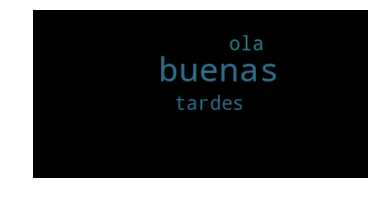

In [179]:
import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate("ola buenas buenas buenas buenas buenas buenas buenas tardes")
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()